# CNN Regression Model (No Scaling)

We'll extend the following regression model to perform multiple regressions because many features we want to predict are vectors instead of single numbers targets. 

https://arxiv.org/pdf/1809.00929


# 1. Load dataset and define training & test sets

In [442]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Conv1D, Reshape, BatchNormalization, DepthwiseConv2D, Activation, AveragePooling2D, SeparableConv2D, Flatten, Dense, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.layers import Lambda
from keras import backend as K


# Load the dataset
with open("../../../datasets/processed/ecog_dataset_livesystem_250hz_32channel.pkl", "rb") as file:
    dataset = pickle.load(file)

# Extract the dataset components
buckets = dataset["buckets"]
targets = dataset["targets"]
channel_info = dataset["channel_info"]

# Prepare the input data and targets
X = []
y = []
for i in range(len(buckets)):
    X.append(buckets[i])   
    y.append(targets[i]["rms"])

X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the number of channels (C) and time samples (T) from the data
C = channel_info["num_channels"]
T = X.shape[2]  # Time samples should be the third dimension (after samples and channels)

print(C, T)

# Ensure the shapes are correct
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

32 50
Shape of X_train: (857, 32, 50)
Shape of X_test: (215, 32, 50)


# 2. Define model

| Layer       | Input Size         | Operation                     | Output Size        | Number of Parameters                |
|-------------|--------------------|-------------------------------|--------------------|-------------------------------------|
| 1           | C × T              | 16 × Conv1D(C,1)              | 16 × 1 × T         | 16C + 16                            |
|             | 16 × 1 × T         | BatchNorm                     | 16 × 1 × T         | 32                                  |
|             | 16 × 1 × T         | Reshape                       | 1 × 16 × T         | -                                   |
|             | 1 × 16 × T         | Dropout(0.25)                 | 1 × 16 × T         | -                                   |
| 2           | 1 × 16 × T         | 4 × Conv2D(2,32)              | 4 × 16 × T         | 4 × 2 × 32 + 4 = 260                |
|             | 4 × 16 × T         | BatchNorm                     | 4 × 16 × T         | 8                                    |
|             | 4 × 16 × T         | Maxpool2d(2,4)                | 4 × 8 × T/4        | -                                    |
|             | 4 × 8 × T/4        | Dropout(0.25)                 | 4 × 8 × T/4        | -                                   |
| 3           | 4 × 8 × T/4        | 4 × Conv2D(8,4)               | 4 × 8 × T/4        | 4 × 4 × 8 × 4 + 4 = 516              |
|             | 4 × 8 × T/4        | BatchNorm                     | 4 × 8 × T/4        | 8                                    |
|             | 4 × 8 × T/4        | Maxpool2d(2,4)                | 4 × 4 × T/16       | -                                    |
|             | 4 × 4 × T/16       | Dropout(0.25)                 | 4 × 4 × T/16       | -                                    |
| 4 (Multiple Regr.)   | 4 × 4 × T/16       | Flatten                       | 4 * 4 * T/16       | -                                   |
|             | 4 * 4 * T/16       | Dense                         | C                  |                |
| Total       |                    |                               |                    |    |


In [443]:
inputs = Input(shape=(C, T))  # Input shape: (C, T)
# Layer 1: Conv1D
x = Conv1D(16, C, padding='same', data_format='channels_first')(inputs)  # 
x = BatchNormalization()(x)  
# Reshape
x = Reshape((1, 16, T))(x)  # Reshape to (1, 16, T)
# Dropout
x = Dropout(0.25)(x)
# Layer 2: Conv2D
x = Conv2D(4, (2, 32), padding='same', data_format='channels_first')(x)   
x = BatchNormalization()(x)   
x = MaxPooling2D((2, 4), data_format='channels_first')(x)   
x = Dropout(0.25)(x)
# Layer 3: Conv2D
x = Conv2D(4, (8, 4), padding='same', data_format='channels_first')(x)   
x = BatchNormalization()(x)   
x = MaxPooling2D((2, 4), data_format='channels_first')(x)   
x = Dropout(0.25)(x)
# Flatten
x = Flatten()(x)  
# Dense layer for multiple regression
outputs = Dense(C, activation='linear')(x)  # Output shape: (C)
# Model definition
model = Model(inputs=inputs, outputs=outputs)

# Define callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='loss', mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Train model

In [444]:
# Train the model
history = model.fit(X_train, y_train, epochs=650, batch_size=32, callbacks=[checkpoint])

Epoch 1/650
27/27 [==============================] - 1s 5ms/step - loss: 19802.0508
Epoch 2/650
27/27 [==============================] - 0s 5ms/step - loss: 19232.5371
Epoch 3/650
27/27 [==============================] - 0s 5ms/step - loss: 18539.2227
Epoch 4/650
27/27 [==============================] - 0s 5ms/step - loss: 17665.9688
Epoch 5/650
27/27 [==============================] - 0s 5ms/step - loss: 16690.5430
Epoch 6/650
27/27 [==============================] - 0s 5ms/step - loss: 15644.8721
Epoch 7/650
27/27 [==============================] - 0s 5ms/step - loss: 14522.8242
Epoch 8/650
27/27 [==============================] - 0s 5ms/step - loss: 13366.9844
Epoch 9/650
27/27 [==============================] - 0s 6ms/step - loss: 12253.9707
Epoch 10/650
27/27 [==============================] - 0s 5ms/step - loss: 11160.1514
Epoch 11/650
27/27 [==============================] - 0s 5ms/step - loss: 10138.7080
Epoch 12/650
27/27 [==============================] - 0s 5ms/step - loss: 

# 4.a Channel-wise evaluation

In [445]:
# Channel-wise evaluation
y_pred = model.predict(X_test)
for channel in range(C):
    channel_mae = np.mean(np.abs(y_test[:, channel] - y_pred[:, channel]))
    channel_rmse = np.sqrt(np.mean((y_test[:, channel] - y_pred[:, channel])**2))
    print(f"Channel {channel+1} - MAE: {channel_mae:.4f}, RMSE: {channel_rmse:.4f}")

7/7 [==============================] - 0s 2ms/step
Channel 1 - MAE: 32.2942, RMSE: 41.6568
Channel 2 - MAE: 28.2078, RMSE: 38.8115
Channel 3 - MAE: 37.8064, RMSE: 47.8569
Channel 4 - MAE: 15.4508, RMSE: 18.9115
Channel 5 - MAE: 43.5563, RMSE: 58.1093
Channel 6 - MAE: 40.3227, RMSE: 56.0162
Channel 7 - MAE: 31.4197, RMSE: 40.3557
Channel 8 - MAE: 42.2275, RMSE: 53.3812
Channel 9 - MAE: 32.9599, RMSE: 47.8963
Channel 10 - MAE: 22.7079, RMSE: 30.6284
Channel 11 - MAE: 21.7150, RMSE: 30.2711
Channel 12 - MAE: 42.0672, RMSE: 55.9612
Channel 13 - MAE: 39.4792, RMSE: 53.5944
Channel 14 - MAE: 32.8950, RMSE: 39.0038
Channel 15 - MAE: 29.4169, RMSE: 37.8843
Channel 16 - MAE: 22.7268, RMSE: 30.0364
Channel 17 - MAE: 32.7562, RMSE: 41.4953
Channel 18 - MAE: 43.5891, RMSE: 58.1993
Channel 19 - MAE: 32.7261, RMSE: 39.4338
Channel 20 - MAE: 51.2770, RMSE: 73.1335
Channel 21 - MAE: 24.0993, RMSE: 32.2090
Channel 22 - MAE: 25.1039, RMSE: 32.3540
Channel 23 - MAE: 42.4059, RMSE: 58.3145
Channel 24 - MA

# 4.b Specific channel evaluation

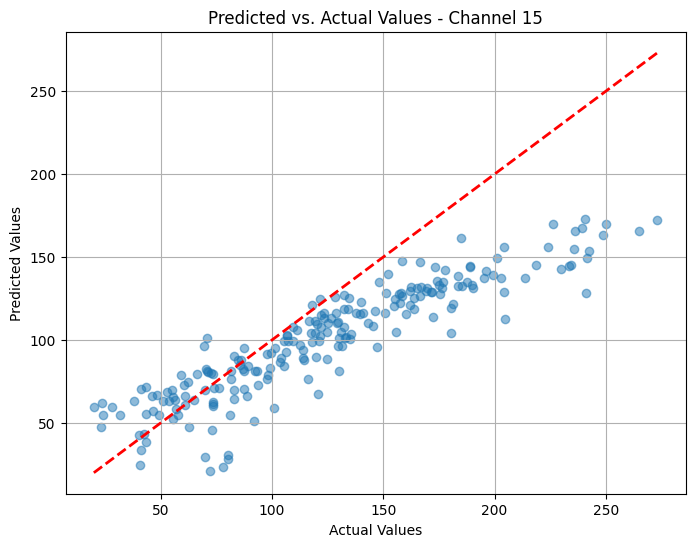

In [451]:
import matplotlib.pyplot as plt

# Select the channel to visualize
channel_to_plot =  14 # Replace with the desired channel index - 1

# Get the predicted and actual values for the selected channel
y_pred_channel = y_pred[:, channel_to_plot]
y_test_channel = y_test[:, channel_to_plot]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_channel, y_pred_channel, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs. Actual Values - Channel {channel_to_plot + 1}")

# Plot the diagonal line representing perfect predictions
min_value = min(np.min(y_test_channel), np.min(y_pred_channel))
max_value = max(np.max(y_test_channel), np.max(y_pred_channel))
plt.plot([min_value, max_value], [min_value, max_value], 'r--', linewidth=2)

plt.grid(True)
plt.show()

RMS, higuchi fractal dimension, spectral entropy and spectral edge density are the best predicted features; The fit is not great however. 